## This notebook reproduces the results found in Riley & Lionello paper - "Mapping Solar Wind Streams from the Sun to 1 AU: A comparison of Techniques."

Note: the Python module used to read the hdf file "data/vr002.hdf" is "tools/psihdf4.py". 

Requirements to run this Jupyter notebook:

Install the following packages to venv:
            1. numpy 
            2. matplotlib 
            3. pyhdf
            4. scipy
 
 
# Step 1: Visualize the data in vr002.hdf. 
### Here, we use the global Heliospheric MHD solutions as the 'ground truth'. 

In [30]:
import matplotlib as mpl
import numpy as np 
from tools.psihdf4 import rdhdf_3d
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import stats
import scipy.optimize as optimization
from scipy.optimize import leastsq


%matplotlib notebook
plt.rcParams['figure.figsize'] = [10, 5] # default fig size.

In [31]:
# read the 3d hdf file. 
hdf_file_path = "data/vr002.hdf"
r, t, p, f = rdhdf_3d(hdf_file_path)

In [32]:
# force periodicity on f
# since the last phi index is less than 2*pi, then we will append 2*pi to phi scale.
p = np.append(p, 2*np.pi) 

In [33]:
# append the first slice p=0 to velocity matrix. 
f = np.append(f,[f[0,:, :]],axis=0)

In [34]:
# change scalers units: 
# Theta: from radians to degrees. colatitude. 
t[0] = 0
t[-1] = np.pi
t_plot = np.pi/2 - t
t_plot = np.sin(t_plot)
fs1 = 12

In [35]:
# Phi: from radians to degrees. longitude.
p = (180/np.pi)*p

In [36]:
# Radius: from solar radii to km. 
# 1 solar radii = 695,700 km
r = (695700)*r

![](figures/mas_conversion.png)

In [37]:
# Velocity profile: PSI convertion units conversion from MAS to cgs. 
f = (481.3711)*f

In [38]:
print("Velocity matrix shape: ", np.shape(f))
print("Phi dim: ", np.shape(f)[0])
print("Theta dim: ", np.shape(f)[1])
print("Radial dim: ", np.shape(f)[2])
print("Velocity matrix dtype: ", f.dtype)

Velocity matrix shape:  (129, 111, 140)
Phi dim:  129
Theta dim:  111
Radial dim:  140
Velocity matrix dtype:  float32


In [39]:
# slice velocity_mat, for r first index (30 solar radii).
v_initial = f[:, :, 0]
print("shape of v_iniital", np.shape(f))
# slice velocity_mat, for r last index(approx 1 AU).
v_final = f[:, :, -1]
print("shape of v_final", np.shape(f))

shape of v_iniital (129, 111, 140)
shape of v_final (129, 111, 140)


In [40]:
# NOTE: pcolorfast and pcolormesh want the coords of pixel corners not centers --> build a "half mesh" for p & t.
# - This means making an array that is n+1 size and has the midpoint positions of the original.
# - Here we clip the endpoints of the half mesh to the original bounds, vs extrapolate.
# - see also https://matplotlib.org/api/_as_gen/matplotlib.pyplot.pcolormesh.html.

cmap = 'gnuplot'

ph = np.concatenate([[p[0]], 0.5 * (p[1:] + p[:-1]), [p[-1]]])
th = np.concatenate([[t_plot[0]], 0.5 * (t_plot[1:] + t_plot[:-1]), [t_plot[-1]]])

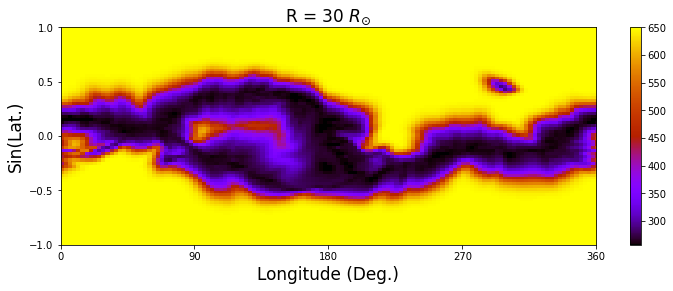

In [41]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (12,4))
ax.set_ylim(-1, 1)
ax.set_xlim(0, 360)
ax.set_title("R = 30 $R_{\odot}$", fontsize=17)
ax.set_ylabel("Sin(Lat.)", fontsize=17)
ax.set_xlabel("Longitude (Deg.)", fontsize=17)
ax.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax.pcolorfast(ph, th, v_initial.T, cmap=cmap)
_ = fig.colorbar(im, ax=ax)
plt.savefig('figures/vr_30rs_map.png')

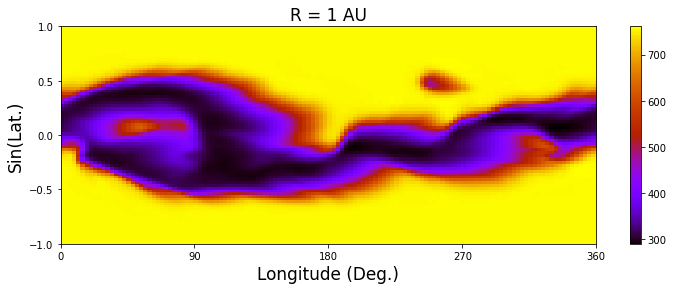

In [42]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (12,4))
ax.set_ylim(-1, 1)
ax.set_xlim(0, 360)
ax.set_title("R = 1 AU", fontsize=17)
ax.set_ylabel("Sin(Lat.)", fontsize=17)
ax.set_xlabel("Longitude (Deg.)", fontsize=17)
ax.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax.pcolorfast(ph, th, v_final.T, cmap=cmap)
_ = fig.colorbar(im, ax=ax)

# Step 2: Apply the HUX (Heliospheric Upwind Extrapolation) Model.


Inviscid Burgers' equation:

$-\Omega_{rot} \frac{\partial v_{r}}{\partial \phi} + v_{r} \frac{\partial v_{r}}{\partial r} = 0$

Then, by the upwind difference algorithm, we get:

$ v_{i+1, j} = v_{i, j} - \Delta r ( a^{+} \Delta^{-} + a^{-}\Delta^{+}) $ 

The indicies i and j refer to the r and $\phi$ grids, respectively. 

Where:

$ a^{+} = \max(-\frac{\Omega_{rot}}{v_{i,j}}, 0)$

$ a^{-} = \min(-\frac{\Omega_{rot}}{v_{i,j}}, 0)$

$ \Delta^{-} = \frac{v_{i,j} - v_{i,j-1}}{\Delta \phi}$

$ \Delta^{+} = \frac{v_{i,j+1} - v_{i,j}}{\Delta \phi}$


Since $\frac{-\Omega_{rot}}{v_{i,j}}$ is always less than zero for the solar wind, then $a^{+} = 0$. Hence,


$ v_{i+1, j} = v_{i, j} + \frac{\Delta r \Omega_{rot}}{v_{i,j}} (\frac{v_{i, j+1} - v_{i,j}}{\Delta \phi}) $ 


Effect of Acceleration: 

Below is a simple expression to mimic residual accelartion from 30 Solar Radii to 1 AU:

$ v_{acc} (r) = \alpha v_{ro} (1-{e}^{\frac{-r}{r_{h}}})$



# HUX-f Pseudocode 

![](figures/HUX_F_pc.png)

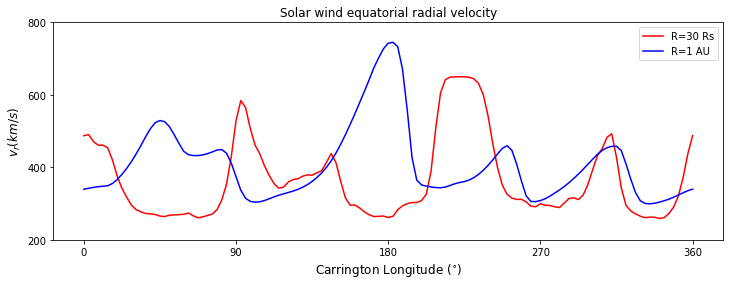

In [43]:
# plot the equator slice theta=90. 
%matplotlib inline
solar_equator_r_30_radii = f[:, 55, 0]
solar_equator_r_1_au = f[:, 55, -1]
fig, ax = plt.subplots(figsize = (12,4))
_ = ax.plot(p, solar_equator_r_30_radii, 'r',label="R=30 Rs")
_ = ax.plot(p, solar_equator_r_1_au, 'b',label="R=1 AU")
_ = ax.set_xlabel("Carrington Longitude ($^{\circ}$)", fontsize=fs1)
_ = ax.set_ylabel('$v_{r} (km/s)$', fontsize=fs1)
_ = ax.set_yticks(ticks=[200, 400, 600, 800])
_ = ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = ax.set_title("Solar wind equatorial radial velocity",fontsize=fs1)
_ = plt.legend()
plt.savefig('figures/vr_30rs_1AU_ts_comp.png')

In [44]:
# setting parameters. 
omega_rot = (2*np.pi)/(25.38*86400) # omega rot at equator.
alpha = 0.15 # accelartion parameter. 
rh = 50* (695700) # accelartion parameter. 

In [45]:
# change phi to be in radian units. 
p = (np.pi/180)*p 

In [46]:
# setting parameters. The phi and radial mesh spacing. 
dp_vec = p[1:] - p[:-1]
dr_vec = r[1:] - r[:-1]

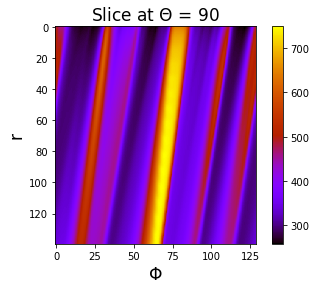

In [47]:
# initial slice
fig4, ax4 = plt.subplots()
_ = im = ax4.imshow(f[:, 55, :].T, cmap=cmap)
_ = fig4.colorbar(im, ax=ax4)
_ = ax4.set_title("Slice at $\Theta$ = 90", fontsize=17)
_ = ax4.set_xlabel("$\Phi$", fontsize=17)
_ = ax4.set_ylabel("r", fontsize=17)

In [67]:
def apply_hux_f_model(r_initial, r, p, omega_rot, dr_vec, dp_vec, alpha, rh, add_v_acc=True):
    """ Apply 1d upwind model to the inviscid burgers equation. r/phi grid."""
    
    v = np.zeros((len(r), len(p))) # initialize array vr.
    v[0, :] = r_initial

    if add_v_acc:
        v_acc = alpha * (v[0, :]*(1 - np.exp(-r[0]/rh)))
        v[0, :] = v_acc + v[0, :]

    for i in range(len(r) -1):
        for j in range(len(p)):

            if j == len(p) -1: # force periodicity 
                v[i+1, j] = v[i+1, 0]

            else:
                if (omega_rot*dr_vec[i])/(dp_vec[j]*v[i,j]) > 1:
                    print(dr_vec[i] - dp_vec[j]*v[i,j]/omega_rot) 
                    print(i, j) # courant condition

                frac1 = (v[i, j + 1] - v[i, j]) / v[i, j]
                frac2 = (omega_rot * dr_vec[i]) / dp_vec[j]
                v[i + 1, j] = v[i, j] + frac1*frac2
            
    return v

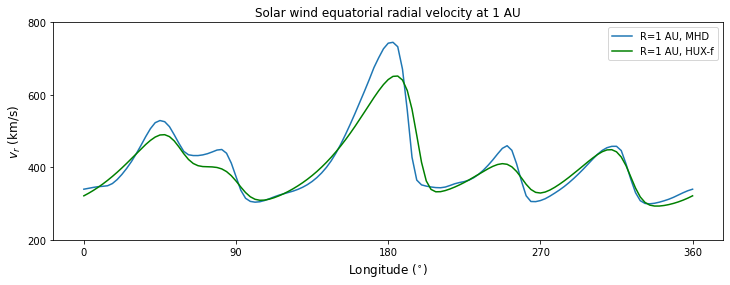

In [69]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (12,4))
_ = ax.plot(180*p/np.pi, solar_equator_r_1_au, label="R=1 AU, MHD")
_ = ax.plot(180*p/np.pi, apply_hux_f_model(solar_equator_r_30_radii, r, p, omega_rot, dr_vec, dp_vec, 0.15, rh)[-1, :], 'g',label="R=1 AU, HUX-f")
_ = ax.set_title("Solar wind equatorial radial velocity at 1 AU",fontsize=fs1)
_ = ax.set_xlabel("Longitude ($^{\circ}$)",fontsize=fs1)
_ = ax.set_yticks(ticks=[200, 400, 600, 800])
_ = ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = ax.set_ylabel('$v_{r}$ (km/s)',fontsize=fs1)
_ = plt.legend()
plt.savefig('figures/vr_1AU_ts_comp_MHD_HUX-f_.png')

## Apply the HUX-f Model to all $\theta$ slices. 

In [50]:
upwind_approx = np.ones((len(p), len(t)))
for ii in range(len(t)):
    upwind_approx[:, ii] = apply_hux_f_model(f[:, ii, 0], r, p, omega_rot, dr_vec, dp_vec, alpha, rh)[-1, :]

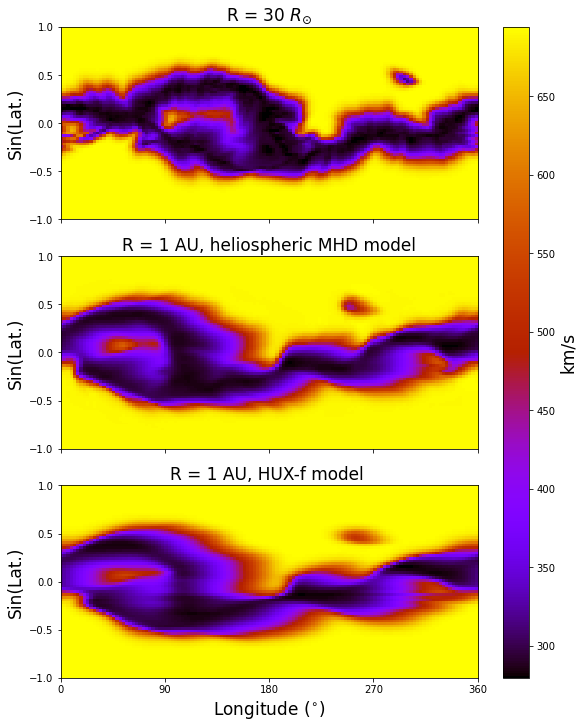

In [66]:
plt.rcParams['figure.figsize'] = [8, 10] # default fig size.

fig, ax = plt.subplots(nrows=3, ncols=1, constrained_layout=True, sharex=True)

ax[0].set_ylim(-1, 1)
ax[0].set_xlim(0, 360)
ax[0].set_title("R = 30 $R_{\odot}$", fontsize=17)
ax[0].set_ylabel("Sin(Lat.)", fontsize=17)
ax[0].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax[0].set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax[0].pcolorfast(ph, th, v_initial.T, cmap=cmap)


ax[1].set_ylim(-1, 1)
ax[1].set_xlim(0, 360)
ax[1].set_title("R = 1 AU, heliospheric MHD model", fontsize=17)
ax[1].set_ylabel("Sin(Lat.)", fontsize=17)
ax[1].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax[1].set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax[1].pcolorfast(ph, th, v_final.T, cmap=cmap)


ax[2].set_ylim(-1, 1)
ax[2].set_xlim(0, 360)
ax[2].set_title("R = 1 AU, HUX-f model ", fontsize=17)
ax[2].set_ylabel("Sin(Lat.)", fontsize=17)
ax[2].set_xlabel("Longitude ($^{\circ}$)", fontsize=17)
ax[2].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax[2].set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax[2].pcolorfast(ph, th, upwind_approx.T, cmap=cmap)
cbar = fig.colorbar(im, ax=ax.flat)
cbar.set_label('km/s', fontsize=17)

plt.savefig('figures/vr_lon_lat_maps_30rs_MHD_HUX-f.png')

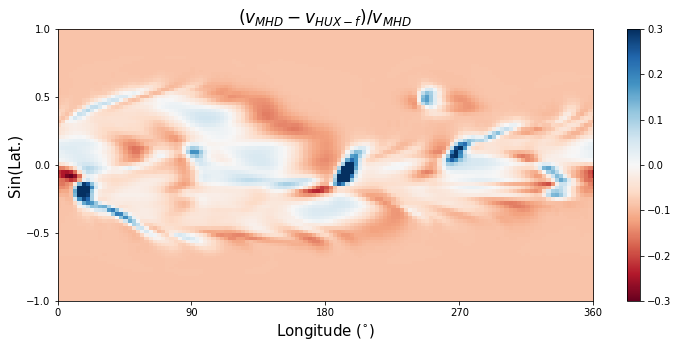

In [52]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5] # default fig size.
fig, ax = plt.subplots(figsize = (12,5))
ax.set_ylim(-1, 1)
ax.set_xlim(0, 360)
ax.set_title("$ (v_{MHD} - v_{HUX-f}) / v_{MHD}$", fontsize=17)
ax.set_ylabel("Sin(Lat.)", fontsize=15)
ax.set_xlabel("Longitude ($^{\circ}$)", fontsize=15)
ax.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
#_ = im1 = ax.contour((180/np.pi)*p , t_plot, np.subtract(upwind_approx.T, v_final.T)/v_final.T, linewidths=2, vmin=-0.3, vmax=0.3)
_ = im2 = ax.pcolorfast(ph, th, np.subtract(upwind_approx.T, v_final.T)/v_final.T, cmap="RdBu", vmin=-0.3, vmax=0.3)
#_ = fig.colorbar(im1, ax=ax, orientation="horizontal", fraction=0.06, pad=0.2)
_ = fig.colorbar(im2, ax=ax)
plt.savefig('figures/error_lon_lat_maps_1AU.png')

In [53]:
print("MSE = ", np.square(np.subtract(upwind_approx, v_final)).mean())

MSE =  3435.4004432599318


### Measure the relative error:

$error = \frac{\| A_{approx} - A\|_{F}}{\| A \|_{F}} $

In [54]:
error_1 = np.linalg.norm(np.subtract(upwind_approx, v_final), ord="fro") / np.linalg.norm(v_final, ord="fro")
acc = 100*(1 - error_1)

In [55]:
print("error = ", error_1)

error =  0.08561095960658631


# Pearson correlation coefficient.


(129, 111)
(129, 111)
(111,)


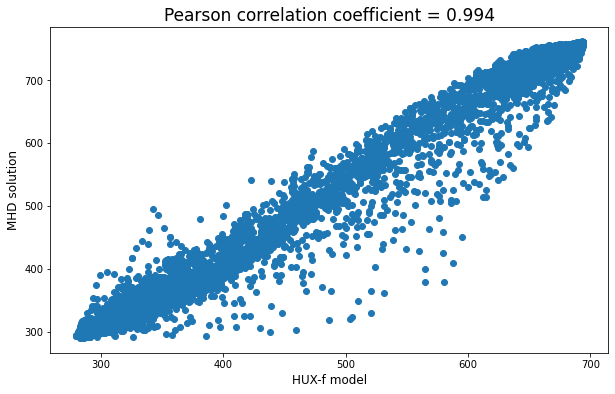

In [56]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (10,6))
ax.scatter(np.matrix.flatten(upwind_approx), np.matrix.flatten(v_final))
ax.set_xlabel("HUX-f model", fontsize=fs1)
ax.set_ylabel("MHD solution", fontsize=fs1)
_ = ax.set_title("Pearson correlation coefficient = " + str(round(stats.pearsonr(np.matrix.flatten(upwind_approx), np.matrix.flatten(v_final))[0], 3)), fontsize=17)
plt.savefig('figures/pearson_CC.png')
print(upwind_approx.shape)
print(v_final.shape)
print(t.shape)

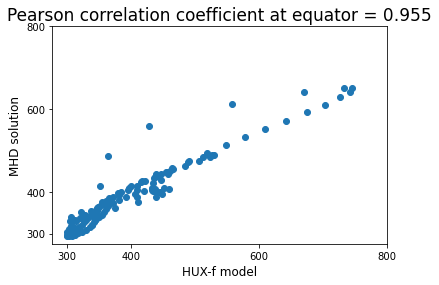

In [57]:
model_at_equator = apply_hux_f_model(solar_equator_r_30_radii, r, p, omega_rot, dr_vec, dp_vec, 0.15, rh)[-1, :]
fig, ax = plt.subplots()
ax.scatter(solar_equator_r_1_au, model_at_equator)
ax.set_xlabel("HUX-f model", fontsize=fs1)
ax.set_ylabel("MHD solution", fontsize=fs1)
ax.set_xticks(ticks=[300, 400, 600, 800])
ax.set_yticks(ticks=[300, 400, 600, 800])
_ = ax.set_title("Pearson correlation coefficient at equator = " + str(round(stats.pearsonr(np.matrix.flatten(model_at_equator), np.matrix.flatten(solar_equator_r_1_au))[0], 3)), fontsize=17)

(129, 111)


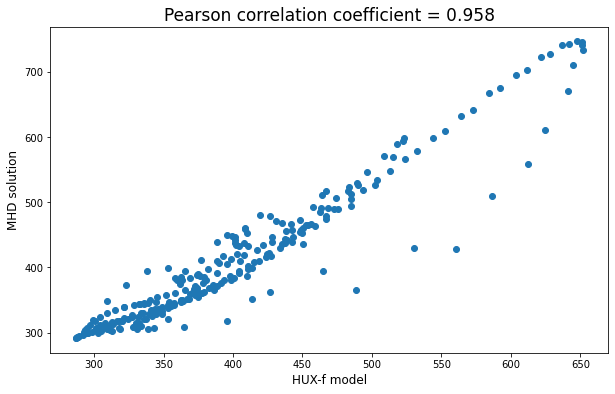

In [58]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (10,6))
ax.scatter(np.matrix.flatten(upwind_approx[...,54:56]), np.matrix.flatten(v_final[...,54:56]))
ax.set_xlabel("HUX-f model", fontsize=fs1)
ax.set_ylabel("MHD solution", fontsize=fs1)
_ = ax.set_title("Pearson correlation coefficient = " + str(round(stats.pearsonr(np.matrix.flatten(upwind_approx[...,54:56]), np.matrix.flatten(v_final[...,54:56]))[0], 3)), fontsize=17)
plt.savefig('figures/pearson_CC_subset.png')
print(upwind_approx.shape)